# Zad 09 - `Zadanie`

**Temat:** Nieliniowe sieci RNN w oparciu o tenzory

 ## **Treść zadania**

Opracować rekurencyjną sieć neuronową która implementuje operacje na dwóch liczbach binarnych zgodnie z wariantem zadania:

**Wariant zadania: `14`** Suma dwóch liczb 28-bitowych

### Kod Python

In [1]:
# Imports
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(seed=1)

# 1. TWORZENIE ZBIORU DANYCH 28-BITOWYCH

sequence_len = 28  # Długość sekwencji dla liczb 28-bitowych
nb_train = 5000    # Zwiększona liczba próbek treningowych

def create_dataset(nb_samples, sequence_len):
    """Tworzy zbiór danych do dodawania binarnego"""
    max_int = 2**(sequence_len-1)
    format_str = '{:0' + str(sequence_len) + 'b}'
    nb_inputs = 2
    nb_outputs = 1

    X = np.zeros((nb_samples, sequence_len, nb_inputs))
    T = np.zeros((nb_samples, sequence_len, nb_outputs))

    for i in range(nb_samples):
        nb1 = np.random.randint(0, max_int)
        nb2 = np.random.randint(0, max_int)

        # Konwersja na binarne i odwrócenie kolejności (LSB pierwszy)
        X[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1)]))
        X[i,:,1] = list(reversed([int(b) for b in format_str.format(nb2)]))
        T[i,:,0] = list(reversed([int(b) for b in format_str.format(nb1+nb2)]))

    return X, T

# Tworzenie danych treningowych
X_train, T_train = create_dataset(nb_train, sequence_len)
print(f'Kształt tensora X_train: {X_train.shape}')
print(f'Kształt tensora T_train: {T_train.shape}')

Kształt tensora X_train: (5000, 28, 2)
Kształt tensora T_train: (5000, 28, 1)


In [2]:
# 2. WARSTWY SIECI NEURONOWEJ

class TensorLinear:
    """Liniowa transformacja tensorowa"""
    def __init__(self, n_in, n_out, tensor_order, W=None, b=None):
        a = np.sqrt(6.0 / (n_in + n_out))
        self.W = np.random.uniform(-a, a, (n_in, n_out)) if W is None else W
        self.b = np.zeros((n_out)) if b is None else b
        self.bpAxes = tuple(range(tensor_order-1))

    def forward(self, X):
        return np.tensordot(X, self.W, axes=((-1),(0))) + self.b

    def backward(self, X, gY):
        gW = np.tensordot(X, gY, axes=(self.bpAxes, self.bpAxes))
        gB = np.sum(gY, axis=self.bpAxes)
        gX = np.tensordot(gY, self.W.T, axes=((-1),(0)))
        return gX, gW, gB

class LogisticClassifier:
    """Klasyfikator logistyczny"""
    def forward(self, X):
        return 1. / (1. + np.exp(-X))

    def backward(self, Y, T):
        return (Y - T) / (Y.shape[0] * Y.shape[1])

    def loss(self, Y, T):
        return -np.mean((T * np.log(Y)) + ((1-T) * np.log(1-Y)))

class TanH:
    """Funkcja aktywacji tanh"""
    def forward(self, X):
        return np.tanh(X)

    def backward(self, Y, output_grad):
        gTanh = 1.0 - (Y**2)
        return gTanh * output_grad

class RecurrentStateUpdate:
    """Aktualizacja stanu rekurencyjnego"""
    def __init__(self, nbStates, W, b):
        self.linear = TensorLinear(nbStates, nbStates, 2, W, b)
        self.tanh = TanH()

    def forward(self, Xk, Sk):
        return self.tanh.forward(Xk + self.linear.forward(Sk))

    def backward(self, Sk0, Sk1, output_grad):
        gZ = self.tanh.backward(Sk1, output_grad)
        gSk0, gW, gB = self.linear.backward(Sk0, gZ)
        return gZ, gSk0, gW, gB

class RecurrentStateUnfold:
    """Rozwijanie stanów w czasie"""
    def __init__(self, nbStates, nbTimesteps):
        a = np.sqrt(6. / (nbStates * 2))
        self.W = np.random.uniform(-a, a, (nbStates, nbStates))
        self.b = np.zeros((self.W.shape[0]))
        self.S0 = np.zeros(nbStates)
        self.nbTimesteps = nbTimesteps
        self.stateUpdate = RecurrentStateUpdate(nbStates, self.W, self.b)

    def forward(self, X):
        S = np.zeros((X.shape[0], X.shape[1]+1, self.W.shape[0]))
        S[:,0,:] = self.S0
        for k in range(self.nbTimesteps):
            S[:,k+1,:] = self.stateUpdate.forward(X[:,k,:], S[:,k,:])
        return S

    def backward(self, X, S, gY):
        gSk = np.zeros_like(gY[:,self.nbTimesteps-1,:])
        gZ = np.zeros_like(X)
        gWSum = np.zeros_like(self.W)
        gBSum = np.zeros_like(self.b)

        for k in range(self.nbTimesteps-1, -1, -1):
            gSk += gY[:,k,:]
            gZ[:,k,:], gSk, gW, gB = self.stateUpdate.backward(
                S[:,k,:], S[:,k+1,:], gSk)
            gWSum += gW
            gBSum += gB

        gS0 = np.sum(gSk, axis=0)
        return gZ, gWSum, gBSum, gS0

In [3]:
# 3. PEŁNA SIEĆ RNN DO DODAWANIA BINARNEGO

class RnnBinaryAdder28bit:
    """RNN do dodawania dwóch 28-bitowych liczb binarnych"""
    def __init__(self, nb_of_inputs, nb_of_outputs, nb_of_states, sequence_len):
        self.tensorInput = TensorLinear(nb_of_inputs, nb_of_states, 3)
        self.rnnUnfold = RecurrentStateUnfold(nb_of_states, sequence_len)
        self.tensorOutput = TensorLinear(nb_of_states, nb_of_outputs, 3)
        self.classifier = LogisticClassifier()
        self.sequence_len = sequence_len

    def forward(self, X):
        recIn = self.tensorInput.forward(X)
        S = self.rnnUnfold.forward(recIn)
        Z = self.tensorOutput.forward(S[:,1:self.sequence_len+1,:])
        Y = self.classifier.forward(Z)
        return recIn, S, Z, Y

    def backward(self, X, Y, recIn, S, T):
        gZ = self.classifier.backward(Y, T)
        gRecOut, gWout, gBout = self.tensorOutput.backward(
            S[:,1:self.sequence_len+1,:], gZ)
        gRnnIn, gWrec, gBrec, gS0 = self.rnnUnfold.backward(
            recIn, S, gRecOut)
        gX, gWin, gBin = self.tensorInput.backward(X, gRnnIn)
        return gWout, gBout, gWrec, gBrec, gWin, gBin, gS0

    def getOutput(self, X):
        recIn, S, Z, Y = self.forward(X)
        return Y

    def getBinaryOutput(self, X):
        return np.around(self.getOutput(X))

    def getParamGrads(self, X, T):
        recIn, S, Z, Y = self.forward(X)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = self.backward(
            X, Y, recIn, S, T)
        return [g for g in itertools.chain(
            np.nditer(gS0),
            np.nditer(gWin),
            np.nditer(gBin),
            np.nditer(gWrec),
            np.nditer(gBrec),
            np.nditer(gWout),
            np.nditer(gBout))]

    def loss(self, Y, T):
        return self.classifier.loss(Y, T)

    def get_params_iter(self):
        return itertools.chain(
            np.nditer(self.rnnUnfold.S0, op_flags=['readwrite']),
            np.nditer(self.tensorInput.W, op_flags=['readwrite']),
            np.nditer(self.tensorInput.b, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.W, op_flags=['readwrite']),
            np.nditer(self.rnnUnfold.b, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.W, op_flags=['readwrite']),
            np.nditer(self.tensorOutput.b, op_flags=['readwrite']))

In [4]:
# 4. TRENOWANIE SIECI

# Hiperparametry
learning_rate = 0.05
momentum_term = 0.80
lambda_rmsprop = 0.5
eps = 1e-6
mb_size = 100
nb_epochs = 50

# Inicjalizacja sieci
nb_of_states = 10  # Zwiększona liczba stanów ukrytych dla 28-bitowych liczb
RNN = RnnBinaryAdder28bit(2, 1, nb_of_states, sequence_len)

# Optymalizator RMSProp z momentum Nesterova
nbParameters = sum(1 for _ in RNN.get_params_iter())
maSquare = [0.0 for _ in range(nbParameters)]
Vs = [0.0 for _ in range(nbParameters)]

losses = []

print("Rozpoczynanie trenowania RNN do dodawania 28-bitowego...")

for epoch in range(nb_epochs):
    epoch_loss = 0
    for i in range(0, X_train.shape[0], mb_size):
        X_batch = X_train[i:i+mb_size]
        T_batch = T_train[i:i+mb_size]

        # Pobranie gradientów
        recIn, S, Z, Y = RNN.forward(X_batch)
        gWout, gBout, gWrec, gBrec, gWin, gBin, gS0 = RNN.backward(
            X_batch, Y, recIn, S, T_batch)

        # Lista gradientów w tej samej kolejności co parametry
        grads = list(itertools.chain(
            np.nditer(gS0),
            np.nditer(gWin),
            np.nditer(gBin),
            np.nditer(gWrec),
            np.nditer(gBrec),
            np.nditer(gWout),
            np.nditer(gBout)))

        # Aktualizacja RMSProp z momentum Nesterova
        for p_idx, param in enumerate(RNN.get_params_iter()):
            # RMSProp
            maSquare[p_idx] = (lambda_rmsprop * maSquare[p_idx] +
                              (1 - lambda_rmsprop) * grads[p_idx]**2)
            grad_norm = grads[p_idx] / (np.sqrt(maSquare[p_idx]) + eps)

            # Nesterov momentum
            Vs[p_idx] = momentum_term * Vs[p_idx] - learning_rate * grad_norm
            param += momentum_term * Vs[p_idx] - learning_rate * grad_norm

        # Obliczanie straty
        batch_loss = RNN.loss(Y, T_batch)
        epoch_loss += batch_loss

    losses.append(epoch_loss / (X_train.shape[0] / mb_size))

    if (epoch + 1) % 5 == 0:
        print(f"Epoka {epoch+1}/{nb_epochs}, Strata: {losses[-1]:.6f}")

Rozpoczynanie trenowania RNN do dodawania 28-bitowego...
Epoka 5/50, Strata: 0.000000
Epoka 10/50, Strata: 0.000000
Epoka 15/50, Strata: 0.000000
Epoka 20/50, Strata: 0.000000
Epoka 25/50, Strata: 0.000000
Epoka 30/50, Strata: 0.000000
Epoka 35/50, Strata: 0.000000
Epoka 40/50, Strata: 0.000000
Epoka 45/50, Strata: 0.000000
Epoka 50/50, Strata: 0.000000


In [5]:
# 5. TESTOWANIE SIECI

def test_addition(RNN, num_tests=10):
    """Testuje sieć na przykładach dodawania"""
    print("\n" + "="*50)
    print("TESTOWANIE DODAWANIA 28-BITOWEGO")
    print("="*50)

    for test in range(num_tests):
        # Generowanie losowych liczb 28-bitowych
        max_int = 2**(sequence_len-1)
        nb1 = np.random.randint(0, max_int)
        nb2 = np.random.randint(0, max_int)

        # Przygotowanie danych wejściowych
        format_str = '{:0' + str(sequence_len) + 'b}'
        x1_bin = list(reversed([int(b) for b in format_str.format(nb1)]))
        x2_bin = list(reversed([int(b) for b in format_str.format(nb2)]))

        X_test = np.zeros((1, sequence_len, 2))
        X_test[0,:,0] = x1_bin
        X_test[0,:,1] = x2_bin

        # Predykcja sieci
        Y_pred = RNN.getBinaryOutput(X_test)

        # Konwersja wyników
        y_bin = ''.join([str(int(d[0])) for d in reversed(Y_pred[0])])
        y_dec = int(y_bin, 2)

        # Oczekiwany wynik
        expected = nb1 + nb2
        expected_bin = format_str.format(expected)

        print(f"\nTest {test+1}:")
        print(f"  Liczba 1: {nb1:10d}  ({format_str.format(nb1)})")
        print(f"  Liczba 2: {nb2:10d}  ({format_str.format(nb2)})")
        print(f"  Oczekiwany: {expected:10d}  ({expected_bin})")
        print(f"  Predykcja:  {y_dec:10d}  ({y_bin.zfill(sequence_len)})")
        print(f"  Poprawny: {'TAK' if y_dec == expected else 'NIE'}")

# Testowanie
test_addition(RNN, num_tests=5)


TESTOWANIE DODAWANIA 28-BITOWEGO

Test 1:
  Liczba 1:   60358080  (0011100110001111110111000000)
  Liczba 2:  106329030  (0110010101100111001111000110)
  Oczekiwany:  166687110  (1001111011110111000110000110)
  Predykcja:   166687110  (1001111011110111000110000110)
  Poprawny: TAK

Test 2:
  Liczba 1:   59577159  (0011100011010001001101000111)
  Liczba 2:   41013270  (0010011100011101000000010110)
  Oczekiwany:  100590429  (0101111111101110001101011101)
  Predykcja:   100590429  (0101111111101110001101011101)
  Poprawny: TAK

Test 3:
  Liczba 1:    7640820  (0000011101001001011011110100)
  Liczba 2:   52787631  (0011001001010111100110101111)
  Oczekiwany:   60428451  (0011100110100001000010100011)
  Predykcja:    60428451  (0011100110100001000010100011)
  Poprawny: TAK

Test 4:
  Liczba 1:   29748544  (0001110001011110110101000000)
  Liczba 2:   83969627  (0101000000010100011001011011)
  Oczekiwany:  113718171  (0110110001110011001110011011)
  Predykcja:   113718171  (0110110001110011

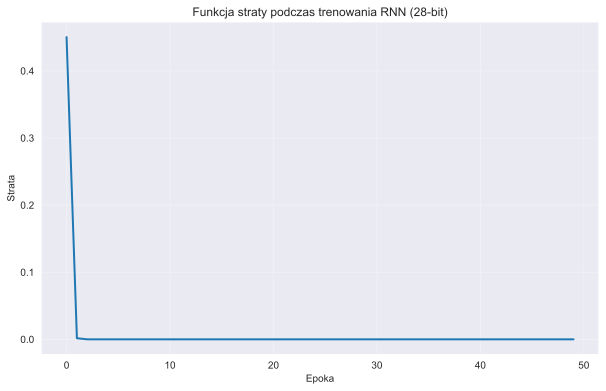


Obliczanie dokładności na zbiorze treningowym...
Dokładność: 100.00%

PRZYKŁAD DODAWANIA
Liczba 1 (bin): 1010010000101111100000110100 = 46265381
Liczba 2 (bin): 1101011100000001111000101110 = 122126571
Suma oczekiwana: 0000100010101110100100000101 = 168391952
Suma predykcja: 0000100010101110100100000101 = 168391952
Poprawna: TAK


In [6]:
# 6. WIZUALIZACJA WYNIKÓW

# Wykres funkcji straty
plt.figure(figsize=(10, 6))
plt.plot(losses, linewidth=2)
plt.title('Funkcja straty podczas trenowania RNN (28-bit)')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.grid(True, alpha=0.3)
plt.show()

# Obliczenie dokładności na całym zbiorze treningowym
print("\nObliczanie dokładności na zbiorze treningowym...")
predictions = RNN.getBinaryOutput(X_train)
predictions = predictions.reshape(T_train.shape)
accuracy = np.mean(predictions == T_train)
print(f"Dokładność: {accuracy*100:.2f}%")

# Przykład działania
print("\n" + "="*50)
print("PRZYKŁAD DODAWANIA")
print("="*50)

def print_sample(x1, x2, t, y=None):
    """Wizualizuje próbkę dodawania"""
    x1_bin = ''.join([str(int(d)) for d in x1])
    x1_dec = int(''.join(reversed(x1_bin)), 2)

    x2_bin = ''.join([str(int(d)) for d in x2])
    x2_dec = int(''.join(reversed(x2_bin)), 2)

    t_bin = ''.join([str(int(d[0])) for d in t])
    t_dec = int(''.join(reversed(t_bin)), 2)

    print(f"Liczba 1 (bin): {x1_bin} = {x1_dec}")
    print(f"Liczba 2 (bin): {x2_bin} = {x2_dec}")
    print(f"Suma oczekiwana: {t_bin} = {t_dec}")

    if y is not None:
        y_bin = ''.join([str(int(d[0])) for d in y])
        y_dec = int(''.join(reversed(y_bin)), 2)
        print(f"Suma predykcja: {y_bin} = {y_dec}")
        print(f"Poprawna: {'TAK' if t_dec == y_dec else 'NIE'}")

# Test na pierwszej próbce
sample_idx = 0
X_sample = X_train[sample_idx:sample_idx+1]
T_sample = T_train[sample_idx:sample_idx+1]
Y_pred = RNN.getBinaryOutput(X_sample)

print_sample(X_train[sample_idx,:,0],
             X_train[sample_idx,:,1],
             T_train[sample_idx,:,:],
             Y_pred[0])